##Catboost with PCA(100) on Image and Text Embeddings 


Submitted by Akriti Gupta, Bhumika Singhal and Namita Shukla

In [1]:
!pip install catboost

     |████████████████████████████████| 76.6 MB 1.4 MB/s 


In [2]:
#  Here we make all the imports required 
import pandas as pd
import numpy as np
import random, time
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix
from tqdm.notebook import tqdm, trange
import json

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Importing all the Concat Embeddings of Text and Images reducing them to 100 dim using PCA. 

In [4]:
concat_embeddings = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_train.csv")
concat_embeddings.rename(columns={"0": "id"}, inplace=True)

In [5]:
concat_embeddings_val = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_dev_unseen.csv")
concat_embeddings_val.rename(columns={"0": "id"}, inplace=True)

In [6]:
concat_embeddings_test_unseen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_test_unseen.csv")
concat_embeddings_test_unseen.rename(columns={"0": "id"}, inplace=True)
concat_embeddings_test_seen = pd.read_csv("/content/gdrive/MyDrive/522-project/Embeddings/concat_pca_embed_150T_50I/ConcatEmbeddings_test_seen.csv")
concat_embeddings_test_seen.rename(columns={"0": "id"}, inplace=True)

Importing all the JSON Files 

In [7]:
train_data = pd.read_json("/content/gdrive/MyDrive/522-project/train.jsonl", lines=True)
train_data.head()
train_data.shape
# batch_size = 32
# chunked_data = split_dataframe(train_data, batch_size)

(8500, 4)

In [8]:
val_data = pd.read_json("/content/gdrive/MyDrive/522-project/dev_unseen.jsonl", lines=True)
val_data.head()
val_data.shape

(540, 4)

In [9]:
test_unseen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_unseen.jsonl", lines=True)
test_unseen_data.head()
test_unseen_data.shape

(2000, 4)

In [10]:
test_seen_data = pd.read_json("/content/gdrive/MyDrive/522-project/test_seen.jsonl", lines=True)
test_seen_data.head()
test_seen_data.shape

(1000, 4)

In [11]:
train_embed = concat_embeddings[concat_embeddings.id.isin(train_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
target_train = train_data["label"].tolist()
print(len(train_embed))

8500


In [12]:
val_embed= concat_embeddings_val[concat_embeddings_val.id.isin(val_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
val_target = val_data["label"].tolist()
len(val_embed)

540

In [13]:
test_unseen_embed= concat_embeddings_test_unseen[concat_embeddings_test_unseen.id.isin(test_unseen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_unseen_target = test_unseen_data["label"].tolist()
len(test_unseen_embed)
len(test_unseen_target)

2000

In [14]:
test_seen_embed= concat_embeddings_test_seen[concat_embeddings_test_seen.id.isin(test_seen_data.id)].concat_embeddings.apply(lambda x : json.loads(x)).tolist()
test_seen_target = test_seen_data["label"].tolist()
len(test_seen_embed)

1000

## Fitting the cocatenated Train embedding on the Catboost Model

We fine tuned the catboost model on various parameters such as :  

1. training iterations
2. regularization penalties of l2.
3. iterations
4. learning rate



In [15]:
train_embed = np.array(train_embed)
target_train = np.array(target_train)
val_embed = np.array(val_embed)
val_target = np.array(val_target)

In [16]:
import sklearn.metrics as metrics
clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.5, 
    loss_function='CrossEntropy',
    depth=3,
    l2_leaf_reg = 2,
    grow_policy= "Depthwise",
    random_strength = 0.1,
    od_type = 'IncToDec'  
)

clf.fit(train_embed, target_train)
# pred_y_cb_val = clf.predict(val_embed)
# pred_y_cb_train =  clf.predict(train_embed)

0:	learn: 0.6179200	total: 78.6ms	remaining: 7.78s
1:	learn: 0.5932019	total: 109ms	remaining: 5.35s
2:	learn: 0.5807795	total: 139ms	remaining: 4.5s
3:	learn: 0.5713482	total: 170ms	remaining: 4.07s
4:	learn: 0.5644684	total: 198ms	remaining: 3.75s
5:	learn: 0.5564893	total: 227ms	remaining: 3.55s
6:	learn: 0.5506868	total: 254ms	remaining: 3.37s
7:	learn: 0.5447196	total: 285ms	remaining: 3.27s
8:	learn: 0.5386307	total: 321ms	remaining: 3.24s
9:	learn: 0.5325438	total: 348ms	remaining: 3.13s
10:	learn: 0.5249548	total: 376ms	remaining: 3.05s
11:	learn: 0.5192896	total: 405ms	remaining: 2.97s
12:	learn: 0.5145006	total: 437ms	remaining: 2.92s
13:	learn: 0.5099523	total: 468ms	remaining: 2.87s
14:	learn: 0.5038572	total: 500ms	remaining: 2.83s
15:	learn: 0.4989468	total: 530ms	remaining: 2.78s
16:	learn: 0.4945813	total: 558ms	remaining: 2.72s
17:	learn: 0.4896976	total: 588ms	remaining: 2.68s
18:	learn: 0.4856152	total: 618ms	remaining: 2.63s
19:	learn: 0.4808613	total: 647ms	remaini

## Testing on the Validation Set

AUC: 0.55725


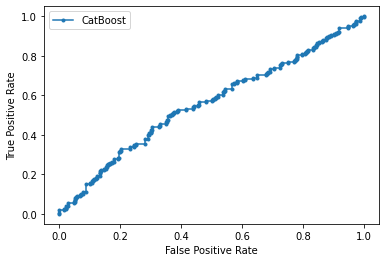

precision :0.4251497005988024 recall :0.355 f1 :0.3869209809264305 accuracy :0.5833333333333334


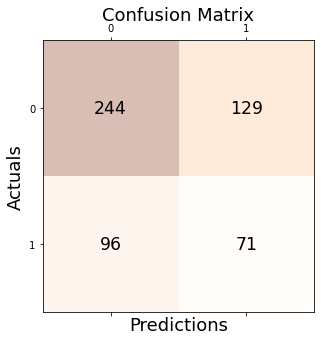

Precision vs Recall


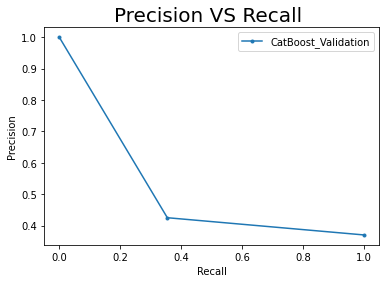

In [17]:
preds = clf.predict(val_embed)
lr_probs = clf.predict_proba(val_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(val_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(val_target, lr_probs)
print("AUC: " + str(lr_auc))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(val_target, preds, average='binary')
acc = accuracy_score(val_target, preds)
r = confusion_matrix(preds, val_target)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(val_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Validation')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

## Testing on Test Seen Data

AUC: 0.5733733493397358


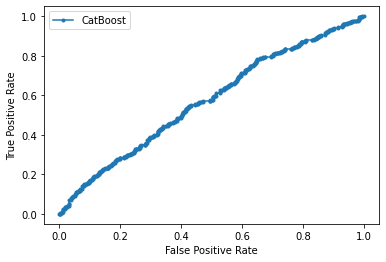

precision :0.5555555555555556 recall :0.32653061224489793 f1 :0.41131105398457585 accuracy :0.542


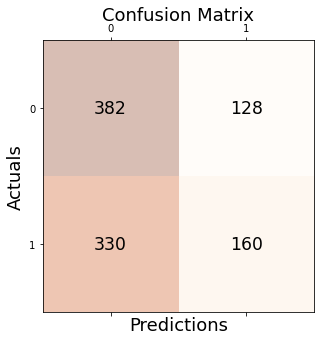

Precision vs Recall


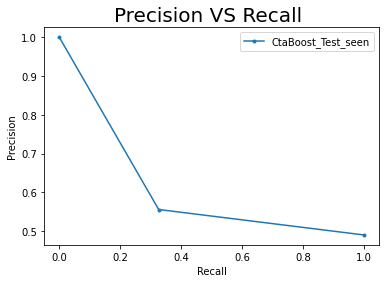

In [18]:
preds = clf.predict(test_seen_embed)
lr_probs = clf.predict_proba(test_seen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_seen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_seen_target, lr_probs)
print("AUC: " + str(lr_auc))

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_seen_target, preds, average='binary')
acc = accuracy_score(test_seen_target, preds)

r = confusion_matrix(test_seen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
print("Precision vs Recall")
precision1, recall1, thresholds = precision_recall_curve(test_seen_target, preds)
pyplot.plot(recall1, precision1, marker='.', label='CtaBoost_Test_seen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

## Testing on the unseen test data

AUC: 0.5017248


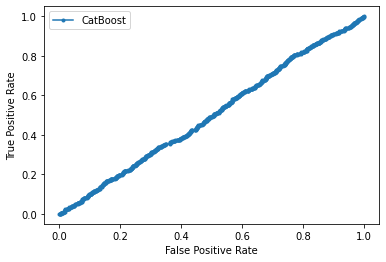

precision :0.3787425149700599 recall :0.3373333333333333 f1 :0.35684062059238364 accuracy :0.544


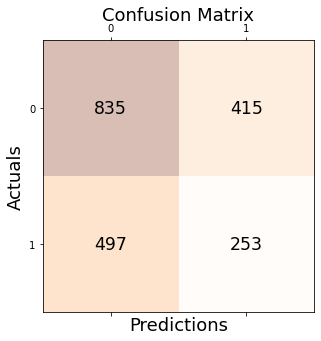

Precision vs Recall


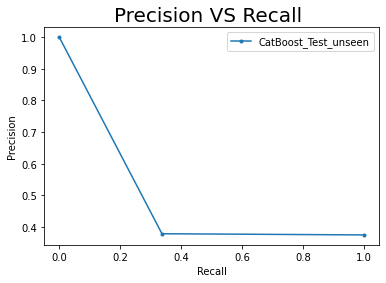

In [19]:
preds = clf.predict(test_unseen_embed)
lr_probs = clf.predict_proba(test_unseen_embed) 
lr_probs = lr_probs[:, 1]

lr_auc = roc_auc_score(test_unseen_target, lr_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_unseen_target, lr_probs)
print("AUC: " + str(lr_auc))

pyplot.plot(lr_fpr, lr_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
precision, recall, f1, _ = precision_recall_fscore_support(test_unseen_target, preds, average='binary')
acc = accuracy_score(test_unseen_target, preds)
r = confusion_matrix(test_unseen_target, preds)
print("precision :"+str(precision) +" recall :"+str(recall)+" f1 :"+ str(f1)  + " accuracy :" + str(acc))

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(r, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        ax.text(x=j, y=i,s=r[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision1, recall1, thresholds = precision_recall_curve(test_unseen_target, preds)
print("Precision vs Recall")
pyplot.plot(recall1, precision1, marker='.', label='CatBoost_Test_unseen')
# axis labels
pyplot.title('Precision VS Recall ', fontsize=20)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()